# Data Validation for Spark Dataframes with whylogs

## About the Dataset - 🛏️ Airbnb Listings in Rio de Janeiro, Brazil

We will read data made available from Airbnb. It's a listing dataset from the city of Rio de Janeiro, Brazil. We'll access data that was adapted from the following location: "http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-01-26/data/listings.csv.gz"

In this example, we want to do some basic data validation. Let's define those:

- Completeness Checks
    - `id` (long): should not contain any missing values
    - `listing_url` (string): should not contain any missing values
    - `last_review` (string): should not contain any missing values
- Consistency Checks
    - `last_review` (string): date should be in the format YYYY-MM-DD
    - `listing_url` (string): should be an url from airbnb (starting with https://www.airbnb.com/rooms/)
    - `latitude` and `longitude` (double): should be within the range of -24 to -22 and -44 to -43 respectively
    - `room_type` (string): frequent strings should be in the set of expected values
- Statistics Checks
    - `reviews_per_month` (double): standard deviation should be in expected range


## Initializing a SparkSession

### Execute the cell below and:

- Select Add Endpoint
- Select Single Sign-On
- Select Create Session, selecting language as Python and in properties use "spark.kubernetes.container.image": "gcr.io/mapr-252711/spark-whylogs-3.5.1:v3.5.1.0.0" the whylogs -integerated spark image in properties.
- Click Create Session

When your session is ready the Manage Sessions pane will become active, providing you the session ID. The session state will become idle which means that you are good to go!

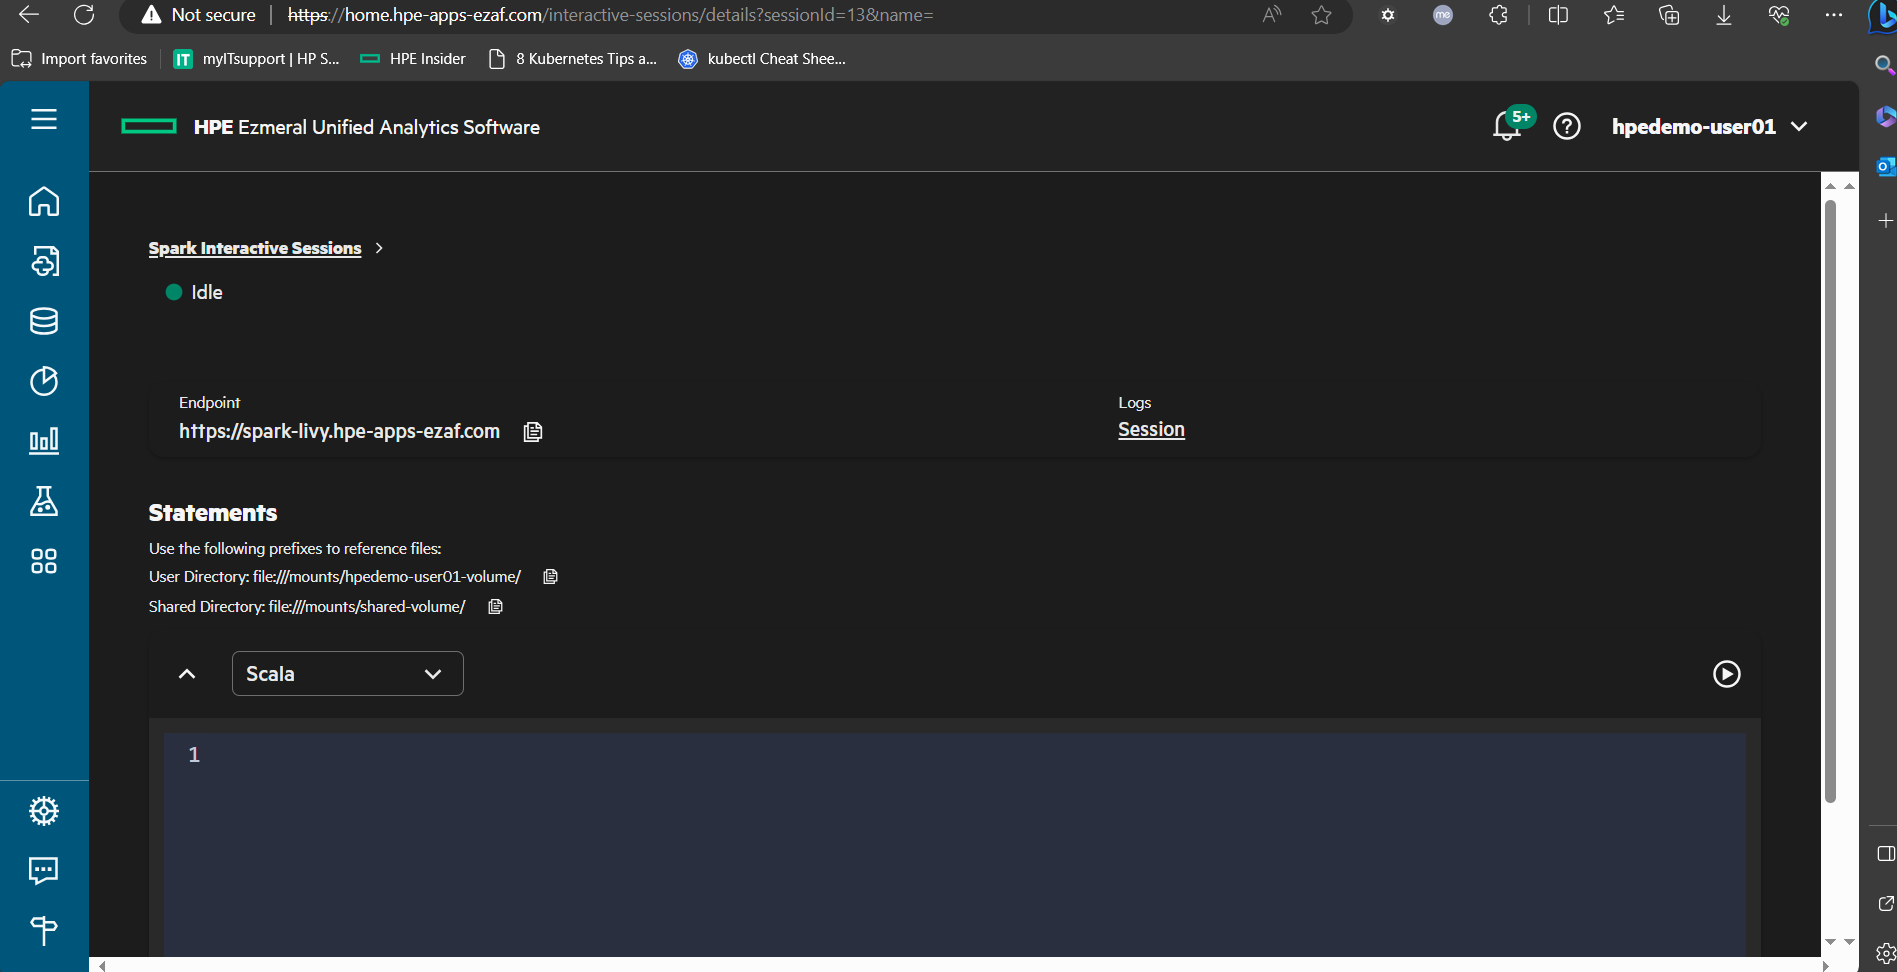

In [1]:
%manage_spark

MagicsControllerWidget(children=(Tab(children=(ManageSessionWidget(children=(HTML(value='<br/>'), HTML(value='…

In [2]:
import os
os.environ['HTTP_PROXY'] = "http://hpeproxy.its.hpecorp.net:443"
os.environ['HTTPS_PROXY'] = "http://hpeproxy.its.hpecorp.net:443"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('whylogs-testing').getOrCreate()
arrow_config_key = "spark.sql.execution.arrow.pyspark.enabled"
spark.conf.set(arrow_config_key, "true")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Creating the PySpark dataframe

In [6]:
from pyspark import SparkFiles
spark_dataframe = spark.read.format('parquet').load("file:///mounts/shared-volume/shared/airbnb_listings.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
spark_dataframe.show(n=1, vertical=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0--------------------------------------
 name                   | Very Nice 2Br in ... 
 description            | Discounts for lon... 
 listing_url            | https://www.airbn... 
 last_review            | 2020-12-26           
 number_of_reviews_ltm  | 13                   
 number_of_reviews_l30d | 0                    
 id                     | 17878                
 latitude               | -22.96592            
 longitude              | -43.17896            
 availability_365       | 286                  
 bedrooms               | 2.0                  
 bathrooms              | null                 
 reviews_per_month      | 2.01                 
 room_type              | Entire home/apt      
only showing top 1 row

In [8]:
spark_dataframe.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- number_of_reviews_ltm: long (nullable = true)
 |-- number_of_reviews_l30d: long (nullable = true)
 |-- id: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- availability_365: long (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- room_type: string (nullable = true)

## Creating the Condition Count Metrics

To create a profile with the standard metrics, we can simply call `collect_dataset_profile_view` from whylog's PySpark extra module. However, if we look at our defined set of constraints, there are two of those that need to checked agains individual values:

- `last_review` (string): date should be in the format YYYY-MM-DD
- `listing_url` (string): should be an url from airbnb (starting with https://www.airbnb.com/rooms/)

As opposed to the other constraints, that can be checked against aggregate metrics, these two need to be checked against individual values. For that, we will create two condition count metrics. Later on, we will create metric constraints based on these metrics.

In [9]:
import datetime
from whylogs.core.relations import Predicate
from typing import Any
from whylogs.core.metrics.condition_count_metric import Condition
from whylogs.core.schema import DeclarativeSchema
from whylogs.core.resolvers import STANDARD_RESOLVER
from whylogs.core.specialized_resolvers import ConditionCountMetricSpec

def date_format(x: Any) -> bool:
    date_format = '%Y-%m-%d'
    try:
        datetime.datetime.strptime(x, date_format)
        return True
    except ValueError:
        return False

last_review_conditions = {"is_date_format": Condition(Predicate().is_(date_format))}
listing_url_conditions = {"url_matches_airbnb_domain": Condition(Predicate().matches("^https:\/\/www.airbnb.com\/rooms"))}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now that we have the our set of conditions for both columns, we can create the condition count metrics. We can do so by creating a Standard Schema and then extending it by adding the condition count metrics with `add_condition_count_metrics`:

In [10]:
schema = DeclarativeSchema(STANDARD_RESOLVER)

schema.add_resolver_spec(column_name="last_review", metrics=[ConditionCountMetricSpec(last_review_conditions)])
schema.add_resolver_spec(column_name="listing_url", metrics=[ConditionCountMetricSpec(listing_url_conditions)])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Profiling the PySpark DataFrame

Now, we can use the schema to pass to our logger through `collect_dataset_profile_view`

In [11]:
from whylogs.api.pyspark.experimental import collect_dataset_profile_view

dataset_profile_view = collect_dataset_profile_view(input_df=spark_dataframe, schema=schema)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This will create a profile with the standard metrics, as well as the two condition count metrics that we created. As a sanity check, let's see the metrics for the `last_review` column:

In [12]:
dataset_profile_view.get_column("last_review").get_metric_names()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['types', 'cardinality', 'counts', 'distribution', 'frequent_items', 'condition_count']

## Creating and Visualizing Metric Constraints

We have all that we need to build our set of constraints. We will use out-of-the-box factory constraints to do that:

In [13]:
from whylogs.core.constraints.factories import condition_meets
from whylogs.core.constraints import ConstraintsBuilder
from whylogs.core.constraints.factories import no_missing_values
from whylogs.core.constraints.factories import is_in_range
from whylogs.core.constraints.factories import stddev_between_range
from whylogs.core.constraints.factories import frequent_strings_in_reference_set

builder = ConstraintsBuilder(dataset_profile_view=dataset_profile_view)
reference_set = {"Entire home/apt", "Private room", "Shared room", "Hotel room"}

builder.add_constraint(condition_meets(column_name="last_review", condition_name="is_date_format"))
builder.add_constraint(condition_meets(column_name="listing_url", condition_name="url_matches_airbnb_domain"))
builder.add_constraint(no_missing_values(column_name="last_review"))
builder.add_constraint(no_missing_values(column_name="listing_url"))
builder.add_constraint(is_in_range(column_name="latitude",lower=-24,upper=-22))
builder.add_constraint(is_in_range(column_name="longitude",lower=-44,upper=-43))
builder.add_constraint(no_missing_values(column_name="id"))
builder.add_constraint(stddev_between_range(column_name="reviews_per_month", lower=0.8, upper=1.1))
builder.add_constraint(frequent_strings_in_reference_set(column_name="room_type", reference_set=reference_set))

constraints = builder.build()
constraints.generate_constraints_report()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[ReportResult(name='last_review meets condition is_date_format', passed=1, failed=0, summary=None), ReportResult(name='last_review has no missing values', passed=0, failed=1, summary=None), ReportResult(name='listing_url meets condition url_matches_airbnb_domain', passed=1, failed=0, summary=None), ReportResult(name='listing_url has no missing values', passed=1, failed=0, summary=None), ReportResult(name='latitude is in range [-24,-22]', passed=1, failed=0, summary=None), ReportResult(name='longitude is in range [-44,-43]', passed=1, failed=0, summary=None), ReportResult(name='id has no missing values', passed=1, failed=0, summary=None), ReportResult(name='reviews_per_month standard deviation between 0.8 and 1.1 (inclusive)', passed=1, failed=0, summary=None), ReportResult(name="room_type values in set {'Hotel room', 'Entire home/apt', 'Shared room', 'Private room'}", passed=1, failed=0, summary=None)]

Now, we can visualize the constraints report using the __Notebook Profile Visualizer__:

In [14]:
from whylogs.viz import NotebookProfileVisualizer
visualization = NotebookProfileVisualizer()
visualization.constraints_report(constraints, cell_height=300)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<IPython.core.display.HTML object>

Looks like we have some missing values for `last_review`.

In [15]:
import os 
os.getcwd() 
visualization.set_profiles(target_profile_view=dataset_profile_view)
visualization.write( rendered_html=visualization.profile_summary(), html_file_name="/mounts/shared-volume/shared/data_validation", )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

You can now load the html from the EZAU platform.